In [39]:
import pandas as pd 
import datetime as dt
from pandas_datareader.data import DataReader
import numpy as np
from pprint import pprint as pp
import matplotlib.pyplot as plt

# Reference: https://srome.github.io/Eigenvesting-I-Linear-Algebra-Can-Help-You-Choose-Your-Stock-Portfolio/

In [22]:
# Grab two years of data
start, end = dt.datetime(2012, 1, 1), dt.datetime(2013, 12, 31)
tickers =  ['AAPL', 'YHOO','GOOG', 'MSFT', 'ALTR','WDC','KLAC'] 

prices = pd.DataFrame() # prices for 2012 for stocks defined in tickers

for ticker in tickers:
    try:
        prices[ticker] = DataReader(ticker, 'yahoo', start, end, retry_count=6).loc[:, 'Close']
    except:
        pass
    
prices.head()

,AAPL,GOOG,MSFT,WDC,KLAC
Date,,,,,
2012-01-03,14.686786,331.462585,26.770000,30.980000,47.459999
2012-01-04,14.765715,332.892242,27.400000,31.299999,46.910000
2012-01-05,14.929643,328.274536,27.680000,32.759998,47.520000
2012-01-06,15.085714,323.796326,28.110001,33.490002,47.730000
2012-01-09,15.061786,310.067780,27.740000,33.750000,48.180000


In [29]:
returns = prices.pct_change()  # returns as change per day
returns = returns.iloc[1:, :]
returns.head() 

,AAPL,GOOG,MSFT,WDC,KLAC
Date,,,,,
2012-01-04,0.005374,0.004313,0.023534,0.010329,-0.011589
2012-01-05,0.011102,-0.013871,0.010219,0.046645,0.013004
2012-01-06,0.010454,-0.013642,0.015535,0.022283,0.004419
2012-01-09,-0.001586,-0.042399,-0.013163,0.007763,0.009428
2012-01-10,0.003580,0.001092,0.003605,-0.006519,0.008095


In [37]:
training_period = 30
# in_sample is Jan-Nov (roughly)
in_sample = returns.iloc[:(returns.shape[0] - training_period), :].copy()
actual_tickers = returns.columns.copy()
in_sample.tail()

,AAPL,GOOG,MSFT,WDC,KLAC
Date,,,,,
2013-11-11,-0.002901,-0.005354,-0.005029,-0.001535,-0.031173
2013-11-12,0.001849,0.001178,-0.006119,0.007965,0.008601
2013-11-13,0.001192,0.020449,0.021413,0.004298,0.009634
2013-11-14,0.014463,0.002673,-0.003669,0.047073,-0.020335
2013-11-15,-0.006002,-0.001613,-0.004734,-0.003955,0.014370


,AAPL,GOOG,MSFT,WDC,KLAC
AAPL,0.000345,0.000067,0.000047,0.000067,0.000067
GOOG,0.000067,0.000207,0.000045,0.000070,0.000052
MSFT,0.000047,0.000045,0.000216,0.000099,0.000079
WDC,0.000067,0.000070,0.000099,0.000545,0.000157
KLAC,0.000067,0.000052,0.000079,0.000157,0.000266


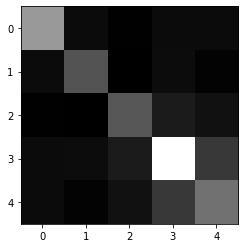

In [46]:
# Make the covariance matrix and investigate it a bit

cov = in_sample.cov()
cov # the covariance of stock returns, diagonals are variance.

# show heat map. White indicates most variance
plt.imshow(cov, cmap='gray') # WDC has highest variance
cov

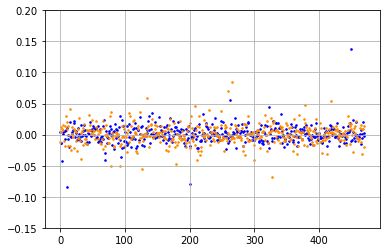

In [95]:
f, a = plt.subplots()
colors = ['red', 'blue', 'orange', 'black', 'darkorange']
for i, at in enumerate(actual_tickers):    
    if ('GOOG' in at) or ('KLAC' in at):
        t = in_sample[at].values
        a.scatter(np.arange(0, t.size), t, marker='.', color=colors[i], s=10)

a.set_ylim([-0.15, 0.2])
a.grid()

In [112]:
var = lambda a: ((a - a.mean()) ** 2).sum() / a.size
print('GOOG', var(in_sample['GOOG'].values) / 1000.0,
      '\nKLAC', var(in_sample['KLAC'].values) / 1000.0)

GOOG 2.0670957986136208e-07 
KLAC 2.653905387112741e-07


In [173]:
# compute eigenvalues and eigenvectors of covariance matrix
evals, evecs = np.linalg.eigh(cov)

# The values indicate amount of risk (he takes largest variance - the riskiest portfolio)
# The vectors indicate weights of the stock: they are linear combination of 
# stocks that minimize variance in uncorrelated ways
print(evals)  # ordered from lowest to highest variance
print('')
print(evecs / evecs.sum(axis=0)) # divide by magnitude of each row
print('')
# I think the rows are dimensions, so column is vector
# Thus the vector components indicate it's weight in each stock "dimension"
# we have chosen a linear combination vector that maximizes positive variance.
# this finds most spread over time (greatest improvement)
print((evecs / evecs.sum(axis=0))[:, -1])  # vector coordinates from 0,0

[0.00015514 0.00017161 0.00020948 0.00033898 0.00070409]

[[ 1.62162318 -0.59566535 -0.67529522  1.06095943  0.15039873]
 [-5.66400748  2.83719689  0.40359344  0.30789421  0.1094339 ]
 [13.33899662  0.13898164  0.99742792  0.11142777  0.13819407]
 [ 1.11981378  0.20713966 -0.69673598 -0.56808031  0.39872016]
 [-9.41642611 -1.58765284  0.97100984  0.0877989   0.20325314]]

[0.15039873 0.1094339  0.13819407 0.39872016 0.20325314]


In [180]:
eport1 = evecs[:, -1] / evecs[:, -1].sum()  # highest variance eigenvector
eport2 = evecs[:, 0] / evecs[:, 0].sum()  # minimim variance, worst improvement
eport1 = pd.DataFrame(data=eport1, columns=['wts1'], index=actual_tickers)
eport2 = pd.DataFrame(data=eport2, columns=['wts2'], index=actual_tickers)

pd.DataFrame({'wts1': eport1.values.T[0], 'wts2': eport2.values.T[0]}, index=actual_tickers)

,wts1,wts2
AAPL,0.150399,1.621623
GOOG,0.109434,-5.664007
MSFT,0.138194,13.338997
WDC,0.398720,1.119814
KLAC,0.203253,-9.416426


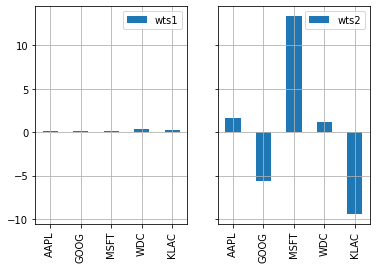

In [182]:
f, a = plt.subplots(1, 2, sharey=True)
eport1.plot(kind='bar', ax=a[0], grid=True)
eport2.plot(kind='bar', ax=a[1], grid=True)


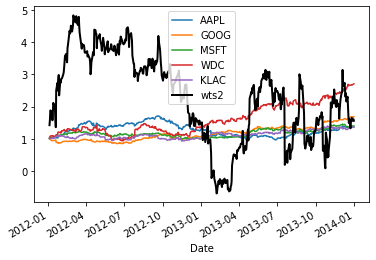

In [194]:
sample = returns
weights = eport2

f, a = plt.subplots()

(1 + sample).cumprod(axis=0).plot(ax=a)
# sum by weights (linear combination of stocks above)
(1 + sample).cumprod(axis=0).dot(weights).plot(linewidth=2, color='black', ax=a)



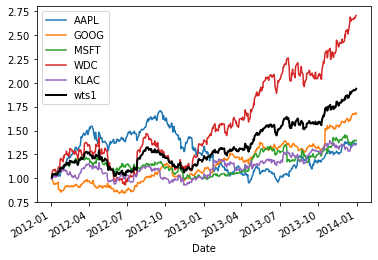

In [195]:
sample = returns
weights = eport1

f, a = plt.subplots()

(1 + sample).cumprod(axis=0).plot(ax=a)
# sum by weights (linear combination of stocks above)
(1 + sample).cumprod(axis=0).dot(weights).plot(linewidth=2, color='black', ax=a)
